## Train energy prediction models for on-top and hollow sites

In this notebook I will train two models that predicts energy for an adsorbate based on a feature vector made from the nearby metal atoms at the adsorption site. The input data is .csv files with extracted feature vectors and energies from DFT data in .db files.

I will train:
* XGBoost regressor for on-top site (OH)
* XGBoost regressor for hollow site (O and H)

#### Import packages

In [117]:
import xgboost
from xgboost import XGBRegressor
import pandas as pd;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import plot_importance
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

In [2]:
def learning_curve(model_name): #For regressor
    # retrieve performance metrics
    results = model_name.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax.plot(x_axis, results['validation_1']['mae'], label='Validation')
    ax.legend()
    
    plt.xlabel("Epoch")
    plt.ylabel('Log Loss')
    plt.title('XGBoost Loss curve')
    plt.show()
    return None

#### Import data from .csv files to a Pandas Dataframe

In [3]:
feature_folder = "../csv_features/"


# Let's import O and H first. Add an initial row that says "I'm an O" or "I'm an H". The hollow model will take care of seperating them. But the data might share patterns that the model can use, even though the adsorbate is different.
def prepare_csv(feature_folder, filename, adsorbate):
    init_df = pd.read_csv(feature_folder + filename)

    # Add a first column about the adsorbate
    adsorbate_df = pd.DataFrame([adsorbate for x in range(len(init_df))], columns = ["adsorbate"])

    #Combine
    prepared_df = pd.concat([adsorbate_df, init_df], axis = 1)
    return prepared_df

H_df = prepare_csv(feature_folder, "H_features.csv", 0) #H kalder vi 0
O_df = prepare_csv(feature_folder, "O_features.csv", 1) #O kalder vi 1

full_df = pd.concat([H_df, O_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns


X = full_df.loc[:, :all_cols[-5]]
y = full_df[["G_ads(eV)"]]

In [4]:
full_df

,adsorbate,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature49,feature50,feature51,feature52,feature53,feature54,G_ads(eV),slab db row,H_out.dbrow,O_out.dbrow
0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,1,1,1,0.152480,1,1.0,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2,-0.102444,1,2.0,NaN
2,0,0,0,0,0,0,0,0,0,0,...,2,1,0,1,0,1,0.064475,1,3.0,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2,-0.063264,1,4.0,NaN
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,0,-0.001436,1,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,1.460288,521,NaN,459.0
495,1,0,0,0,0,0,0,0,0,0,...,1,0,3,0,0,0,1.696832,522,NaN,389.0
496,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,3,0,1.222140,523,NaN,415.0
497,1,0,0,0,1,0,0,0,0,0,...,0,0,0,3,0,0,2.425709,524,NaN,421.0


In [46]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , early_stopping_rounds = 5
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = True) #evals


[13:41:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mae:0.78906	validation_1-mae:0.74622
[1]	validation_0-mae:0.71388	validation_1-mae:0.67502
[2]	validation_0-mae:0.64650	validation_1-mae:0.61099
[3]	validation_0-mae:0.58647	validation_1-mae:0.55411
[4]	validation_0-mae:0.53298	validation_1-mae:0.50531
[5]	validation_0-mae:0.48464	validation_1-mae:0.45898
[6]	validation_0-mae:0.44224	validation_1-mae:0.41967
[7]	validation_0-mae:0.40329	validation_1-mae:0.38442
[8]	validation_0-mae:0.36925	validation_1-mae:0.35236
[9]	validation_0-mae:0.33819	valid

/Users/marcusnorgaardweng/miniforge3/envs/PUK/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[68]	validation_0-mae:0.05443	validation_1-mae:0.06795
[69]	validation_0-mae:0.05397	validation_1-mae:0.06743
[70]	validation_0-mae:0.05370	validation_1-mae:0.06736
[71]	validation_0-mae:0.05315	validation_1-mae:0.06676
[72]	validation_0-mae:0.05262	validation_1-mae:0.06679
[73]	validation_0-mae:0.05221	validation_1-mae:0.06592
[74]	validation_0-mae:0.05175	validation_1-mae:0.06563
[75]	validation_0-mae:0.05124	validation_1-mae:0.06544
[76]	validation_0-mae:0.05085	validation_1-mae:0.06532
[77]	validation_0-mae:0.05034	validation_1-mae:0.06513
[78]	validation_0-mae:0.04981	validation_1-mae:0.06496
[79]	validation_0-mae:0.04942	validation_1-mae:0.06485
[80]	validation_0-mae:0.04905	validation_1-mae:0.06433
[81]	validation_0-mae:0.04870	validation_1-mae:0.06370
[82]	validation_0-mae:0.04825	validation_1-mae:0.06381
[83]	validation_0-mae:0.04786	validation_1-mae:0.06370
[84]	validation_0-mae:0.04750	validation_1-mae:0.06351
[85]	validation_0-mae:0.04725	validation_1-mae:0.06308
[86]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

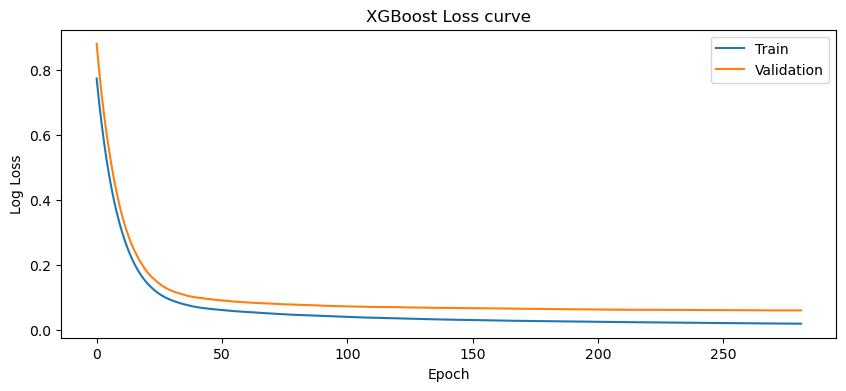

Training score:  0.9990914615851553
Validation score:  0.9928764877019151


In [6]:
learning_curve(XGBModel)

score = XGBModel.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)


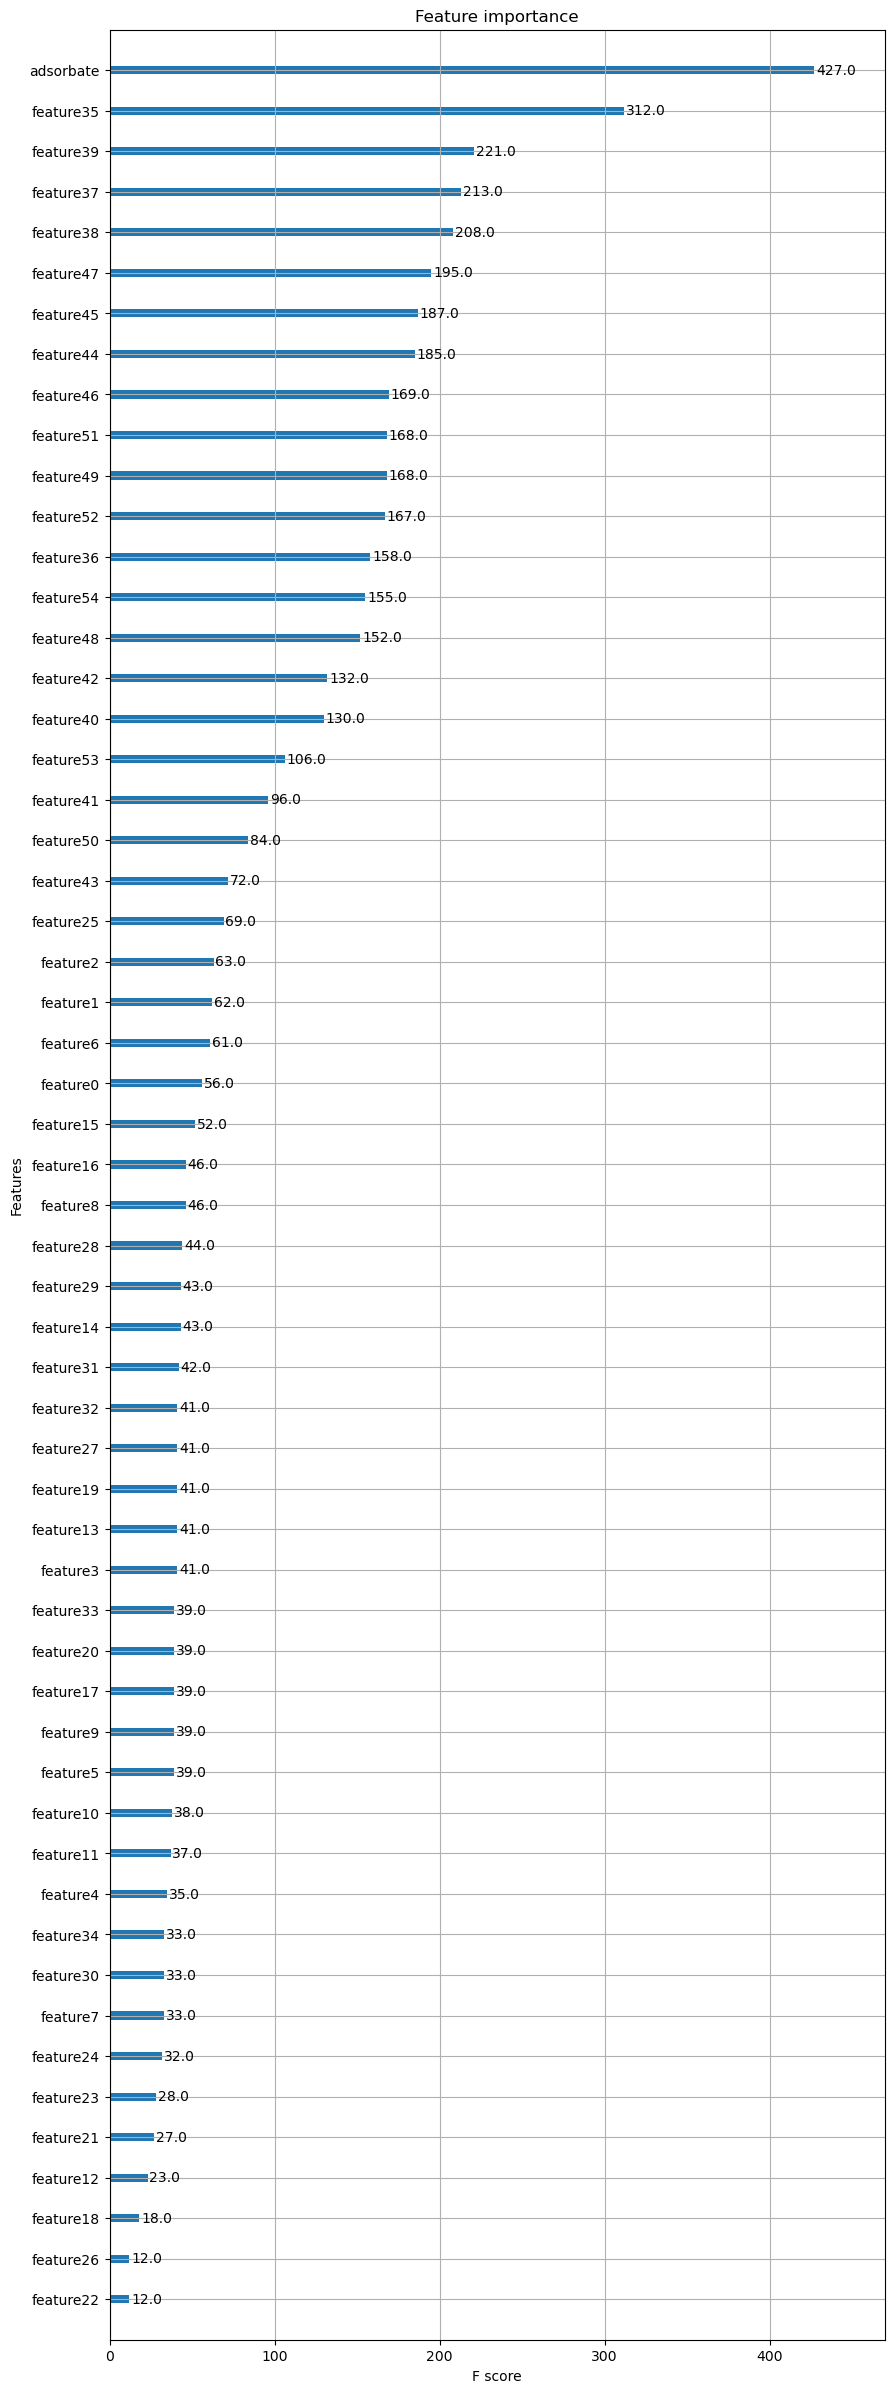

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (10, 30))
plot_importance(XGBModel, ax = ax, max_num_features = 160)
plt.show()

## Parity plot

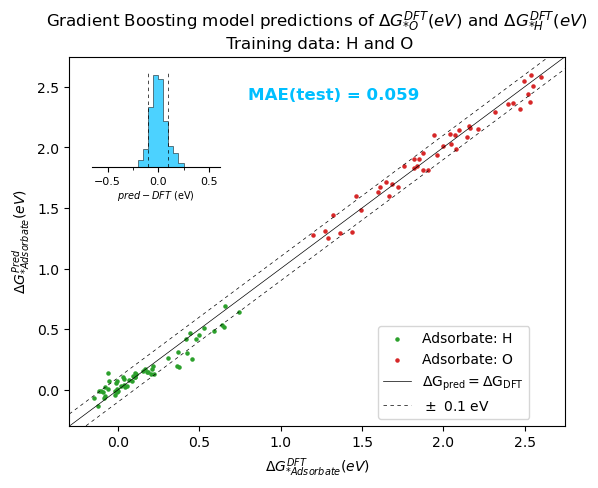

In [131]:
def single_parity_plot(model_name, X_test, y_test_series):
    model_predictions = XGBModel.predict(X_test)
    y_test = y_test_series.values.tolist()
    
    # Find MAE:
    errors = y_test_series.to_numpy().reshape(-1)-model_predictions
    MAE = np.mean(np.abs(errors))
    #print(f"MAE: {MAE:.3f}")
    
    #I want two plt.scatter, one for each adsorbate
    flat_list = [item for sublist in X_test[["adsorbate"]].values.tolist() for item in sublist]
    pred_H = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 0]
    pred_O = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 1]
    true_H = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 0]
    true_O = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 1]
    
    fig, ax1 = plt.subplots()
    
    ax1.scatter(true_H, pred_H, s = 5, c = "tab:green", label = "Adsorbate: H")
    ax1.scatter(true_O, pred_O, s = 5, c = "tab:red", label = "Adsorbate: O")
    #plt.scatter(y_test_series, model_predictions)
    
    ax1.set_title("Gradient Boosting model predictions of $\Delta G_{*O}^{DFT} (eV)$ and $\Delta G_{*H}^{DFT} (eV)$ \n Training data: H and O")
    
    ax1.set_xlabel("$\Delta G_{*Adsorbate}^{DFT} (eV)$")
    ax1.set_ylabel("$\Delta G_{*Adsorbate}^{Pred} (eV)$")
    
    ax1.text(0.8, 2.4, f"MAE(test) = {MAE:.3f}", color="deepskyblue", fontweight='bold', fontsize = 12)
    
    left, bottom, width, height = [0.16, 0.65, 0.2, 0.2]
    ax_inset = fig.add_axes([left, bottom, width, height])
    
    
    
    pm, lw, fontsize = 0.1, 0.5, 14

    ax_inset.hist(errors, bins=np.arange(-0.6, 0.6, 0.05),
          color="deepskyblue",
          density=True,
          alpha=0.7,
          histtype='stepfilled',
          ec='black',
          lw=lw)
    
    # Make plus/minus 0.1 eV lines in inset axis
    ax_inset.axvline(pm, color='black', ls='--', dashes=(5, 5), lw=lw)
    ax_inset.axvline(-pm, color='black', ls='--', dashes=(5, 5), lw=lw)
    
    # Set x-tick label fontsize in inset axis
    ax_inset.tick_params(axis='x', which='major', labelsize=fontsize-6)
    
    # Remove y-ticks in inset axis
    ax_inset.tick_params(axis='y', which='major', left=False, labelleft=False)
    
    # Set x-tick locations in inset axis
    ax_inset.xaxis.set_major_locator(ticker.MultipleLocator(0.50))
    ax_inset.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    
    # Remove the all but the bottom spines of the inset axis
    for side in ['top', 'right', 'left']:
        ax_inset.spines[side].set_visible(False)
    
    # Make the background transparent in the inset axis
    ax_inset.patch.set_alpha(0.0)
    
    # Print 'pred-calc' below inset axis
    ax_inset.text(0.5, -0.33,
                  '$pred - DFT$ (eV)',
                  ha='center',
                  transform=ax_inset.transAxes,
                  fontsize=fontsize-7)
    
    # Make central and plus/minus 0.1 eV lines in scatter plot
    lims = [-0.3, 2.75]
    
    # Set x and y limits
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    
    ax1.plot(lims, lims,
            lw=lw, color='black', zorder=1,
            label=r'$\rm \Delta G_{pred} = \Delta G_{DFT}$')
    
    # Make plus/minus 0.1 eV lines around y = x
    ax1.plot(lims, [lims[0]+pm, lims[1]+pm],
            lw=lw, ls='--', dashes=(5, 5), color='black', zorder=1,
            label=r'$\rm \pm$ {:.1f} eV'.format(pm))
            
    ax1.plot([lims[0], lims[1]], [lims[0]-pm, lims[1]-pm],
            lw=lw, ls='--', dashes=(5, 5), color='black', zorder=1)
    
    fig.legend(loc = "lower right", borderaxespad=5)
    
    plt.show()
    return None

single_parity_plot(XGBModel, X_test, y_test)


In [60]:
model_predictions = XGBModel.predict(X_test)
print(model_predictions)

[ 1.8132985   1.9074707   1.8131584   0.06994569 -0.01112599  0.02956216
 -0.02202519  0.18774989  1.6768233   0.13457607  0.14252117  2.104209
  1.2752528   0.08443429  1.7180057   0.11589682  1.2548064   0.14878388
 -0.02252639  0.03474479  0.53365093  0.12822652  0.64136666  2.3677604
  0.19630834  0.25073928  2.1761363   2.104046    0.16931255  1.8458023
  2.2945142   0.13123989  0.4529454   0.1035068   2.3727527   2.0820086
  2.5092456   1.4417714   0.09046523  0.02529829  0.69066495  0.26169854
  2.1633816   0.00345513  2.3580701   2.1551504   1.2922171   2.3140755
 -0.13177943  2.027329    0.15288402  2.0079162   2.114677    2.5956569
  2.1413155  -0.00864208  0.03767516  1.6706889   0.30182737 -0.01248039
  1.304742    0.5116165   0.05971861 -0.07134425  0.5156      1.59861
  1.6025246   0.31417963  0.07120683  1.8487064   1.9841095   0.41506675
  1.8293338   1.9337126   0.17527011  1.4875698   0.19652139  0.10229783
 -0.01388737 -0.04280058  0.42007226  0.1394059   0.10830577 

In [67]:
print(np.mean(np.abs(y_test.to_numpy().reshape(-1)-model_predictions)))

0.058643420995946945


In [23]:
flat_list = [item for sublist in X_test[["adsorbate"]].values.tolist() for item in sublist]
flat_list

[0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]